# Exercise 3 — Feature Engineering & Selection (OLS + sklearn, OLS-only comparison)

This notebook shows how to improve a linear model on a **non‑linear dataset** using **polynomial features** and **feature selection**.
We will **fit with both** `statsmodels` (OLS, for inference) and `sklearn` (for quick prediction metrics), but the **model comparison table is OLS‑only**, as requested.

**Flow**
1) Load & preview data  
2) Split into X (features) and y (target)  
3) Helpers to fit/report OLS  
4) Baseline model (OLS) + optional sklearn fit (info only)  
5) Polynomial features (degree ≤ 4) with dataset preview  
6) Backward Elimination (p‑values)  
7) Forward Selection (Adj R²)  
8) OLS‑only model comparison + pick winner  
9) Coefficients & residual diagnostics for the winner  
10) Quick metrics + full OLS summary


## Cell 1 — Imports

In [1]:
# PURPOSE OF THIS CELL:
# - Import all required libraries for data handling, modeling, and plotting.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from pathlib import Path


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 2 — Load dataset & preview

In [3]:
# PURPOSE OF THIS CELL:
# - Load 'non-linear-data-set-for-regression.csv' if present.
# - Otherwise, generate a synthetic non-linear dataset so the notebook runs.
# - Show the first few rows and column names.

path = Path("/content/drive/MyDrive/IIT Bombay/non-linear-data-set-for-regression.csv")
if path.exists():
    df = pd.read_csv(path)
    print("Loaded: non-linear-data-set-for-regression.csv")
else:
    rng = np.random.default_rng(0)
    X = np.linspace(-3, 3, 160)
    y = 0.8*X**3 - 1.5*X**2 + 2.0*X + rng.normal(0, 2.0, size=X.size)
    df = pd.DataFrame({"X": X, "Y": y})
    print("NOTE: Using synthetic demo data (file not found).")

print("Head:")
print(df.head())
print("\nColumns:", list(df.columns))

Loaded: non-linear-data-set-for-regression.csv
Head:
          y        x1
0  0.571545  0.000000
1  0.634194  0.005556
2  0.871166  0.011111
3  1.061598  0.016667
4  0.369627  0.022222

Columns: ['y', 'x1']


## Cell 3 — Split into features (X) and target (y)

In [4]:
# PURPOSE OF THIS CELL:
# - Separate y (target) and X (features). If 'Y' exists, use it; else first column is y.

if "Y" in df.columns:
    y = df["Y"].copy()
    X_base = df.drop(columns=["Y"]).copy()
else:
    y = df.iloc[:, 0].copy()
    X_base = df.iloc[:, 1:].copy()

print("Shapes -> X_base:", X_base.shape, "| y:", y.shape)

Shapes -> X_base: (181, 1) | y: (181,)


## Cell 4 — Helper functions for OLS (fit & report)

In [5]:
# PURPOSE OF THIS CELL:
# - Define helpers to fit OLS with an intercept and to print key metrics.

def fit_ols(Xmat, y):
    X_sm = sm.add_constant(Xmat)  # add intercept 'const'
    return sm.OLS(y, X_sm).fit()

def report_model(name, model):
    print(f"\n=== {name} ===")
    print("R²        :", round(model.rsquared, 4))
    print("Adj R²    :", round(model.rsquared_adj, 4))
    print("AIC / BIC :", round(model.aic, 2), "/", round(model.bic, 2))
    print("Parameters:", int(model.df_model))  # slopes only (excl. intercept)

## Cell 5 — Baseline model (OLS) + optional sklearn info

In [6]:
# PURPOSE OF THIS CELL:
# - Fit OLS on raw features and print metrics.
# - Optionally fit sklearn LinearRegression (not used in the model-comparison table).

ols_baseline = fit_ols(X_base, y)
report_model("Baseline (OLS, raw features)", ols_baseline)

try:
    sk_base = LinearRegression().fit(X_base, y)
    y_hat_base = sk_base.predict(X_base)
    print("\n--- Baseline (sklearn, info only) ---")
    print("Intercept (c):", sk_base.intercept_)
    print("Slopes (mᵢ):", dict(zip(X_base.columns, sk_base.coef_)))
    print("R² (sklearn):", r2_score(y, y_hat_base))
    print("MAE:", mean_absolute_error(y, y_hat_base))
    print("RMSE:", np.sqrt(mean_squared_error(y, y_hat_base)))
except Exception as e:
    print("sklearn baseline fit skipped due to:", e)


=== Baseline (OLS, raw features) ===
R²        : 0.4842
Adj R²    : 0.4813
AIC / BIC : 290.23 / 296.63
Parameters: 1

--- Baseline (sklearn, info only) ---
Intercept (c): 1.3918649294795795
Slopes (mᵢ): {'x1': np.float64(-1.780793573920485)}
R² (sklearn): 0.48419408084826465
MAE: 0.4489040054461125
RMSE: 0.5335262856725673


## Cell 6 — Polynomial Feature Expansion (degree ≤ 4)

In [7]:
# PURPOSE OF THIS CELL:
# - Expand X_base into polynomial terms (powers & interactions) using PolynomialFeatures.
# - include_bias=False because we add intercept separately in OLS via sm.add_constant().
# - Show shape and head of X_poly and fit an OLS model with all polynomial features.

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly_array = poly.fit_transform(X_base)
X_poly = pd.DataFrame(X_poly_array, columns=poly.get_feature_names_out(X_base.columns))

print("Polynomial features created! Shape:", X_poly.shape)
print("\nPreview of polynomial feature dataset:")
print(X_poly.head())

ols_poly_all = fit_ols(X_poly, y)
report_model("Polynomial ALL (OLS, degree ≤ 4)", ols_poly_all)

Polynomial features created! Shape: (181, 4)

Preview of polynomial feature dataset:
         x1      x1^2          x1^3          x1^4
0  0.000000  0.000000  0.000000e+00  0.000000e+00
1  0.005556  0.000031  1.714678e-07  9.525990e-10
2  0.011111  0.000123  1.371742e-06  1.524158e-08
3  0.016667  0.000278  4.629630e-06  7.716050e-08
4  0.022222  0.000494  1.097394e-05  2.438653e-07

=== Polynomial ALL (OLS, degree ≤ 4) ===
R²        : 0.8198
Adj R²    : 0.8157
AIC / BIC : 105.91 / 121.9
Parameters: 4


## Cell 7 — Backward Elimination (OLS, p-value based)

In [8]:
# PURPOSE OF THIS CELL:
# - Iteratively drop the feature with the highest p-value if p > 0.05 until all remaining features are significant.

def backward_elimination(X_df, y, p_thresh=0.05):
    X_curr = X_df.copy()
    while True:
        mdl = fit_ols(X_curr, y)
        pvals = mdl.pvalues.drop("const", errors="ignore")
        worst_feat = pvals.idxmax()
        worst_p = pvals.max()
        if worst_p <= p_thresh:
            return X_curr, mdl
        X_curr = X_curr.drop(columns=[worst_feat])

X_be, ols_be = backward_elimination(X_poly, y, p_thresh=0.05)
report_model("Backward Elimination (OLS from poly)", ols_be)
print("Selected features (Backward):", list(X_be.columns))


=== Backward Elimination (OLS from poly) ===
R²        : 0.8192
Adj R²    : 0.8161
AIC / BIC : 104.48 / 117.27
Parameters: 3
Selected features (Backward): ['x1', 'x1^2', 'x1^3']


## Cell 8 — Forward Selection (OLS, greedily maximize Adj R²)

In [9]:
# PURPOSE OF THIS CELL:
# - Start with no features and add the one that maximizes Adjusted R² at each step, stopping when no improvement is possible.

def forward_selection(X_df, y):
    remaining = list(X_df.columns)
    selected = []
    best_adj = -np.inf
    best_model = None

    while remaining:
        scores = []
        for cand in remaining:
            cols = selected + [cand]
            mdl = fit_ols(X_df[cols], y)
            scores.append((mdl.rsquared_adj, cand, mdl))
        scores.sort(key=lambda t: t[0], reverse=True)
        top_adj, top_cand, top_mdl = scores[0]
        if top_adj > best_adj + 1e-9:
            selected.append(top_cand)
            remaining.remove(top_cand)
            best_adj, best_model = top_adj, top_mdl
        else:
            break
    return selected, best_model

fs_selected, ols_fs = forward_selection(X_poly, y)
report_model("Forward Selection (OLS from poly)", ols_fs)
print("Selected features (Forward, order):", fs_selected)


=== Forward Selection (OLS from poly) ===
R²        : 0.8198
Adj R²    : 0.8157
AIC / BIC : 105.91 / 121.9
Parameters: 4
Selected features (Forward, order): ['x1', 'x1^4', 'x1^2', 'x1^3']


## Cell 9 — Model comparison (OLS-only) + pick winner

In [10]:
# PURPOSE OF THIS CELL:
# - Compare OLS models (Baseline, Poly ALL, Backward, Forward), sorted by Adj R² desc then AIC asc.
# - Pick a winner for diagnostics.

def pack(name, mdl):
    return (name, mdl.rsquared, mdl.rsquared_adj, mdl.aic, mdl.bic)

compare_ols = pd.DataFrame([
    pack("Baseline (OLS)",     ols_baseline),
    pack("Poly ALL (OLS)",     ols_poly_all),
    pack("Backward (OLS)",     ols_be),
    pack("Forward (OLS)",      ols_fs),
], columns=["Model", "R2_OLS", "Adj_R2_OLS", "AIC", "BIC"])

print("Model comparison (OLS only):")
print(compare_ols.sort_values(["Adj_R2_OLS", "AIC"], ascending=[False, True]).reset_index(drop=True))

best_row = compare_ols.sort_values(["Adj_R2_OLS", "AIC"], ascending=[False, True]).iloc[0]
best_name = best_row["Model"]
print("\nBest (by Adj_R2, tie-break AIC):", best_name)

best_model = {
    "Baseline (OLS)": ols_baseline,
    "Poly ALL (OLS)": ols_poly_all,
    "Backward (OLS)": ols_be,
    "Forward (OLS)" : ols_fs
}[best_name]

Model comparison (OLS only):
            Model    R2_OLS  Adj_R2_OLS         AIC         BIC
0  Backward (OLS)  0.819201    0.816136  104.480329  117.274317
1   Forward (OLS)  0.819772    0.815676  105.907396  121.899881
2  Poly ALL (OLS)  0.819772    0.815676  105.907396  121.899881
3  Baseline (OLS)  0.484194    0.481312  290.230357  296.627351

Best (by Adj_R2, tie-break AIC): Backward (OLS)


## Cell 10 — Coefficients & residual diagnostics (winner)


=== Coefficients for Backward (OLS) ===
x1^2    -33.215525
const     0.344024
x1       11.283478
x1^3     22.349048
dtype: float64


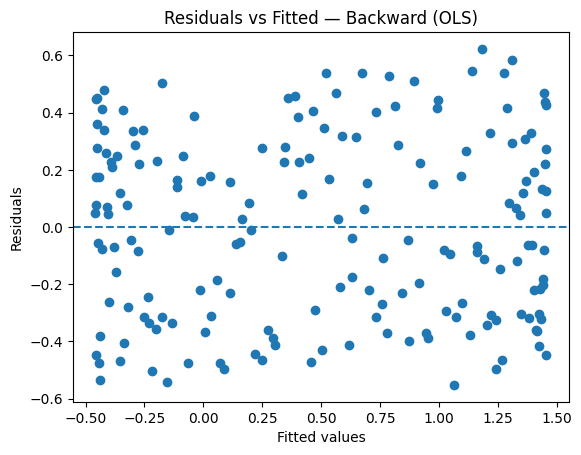

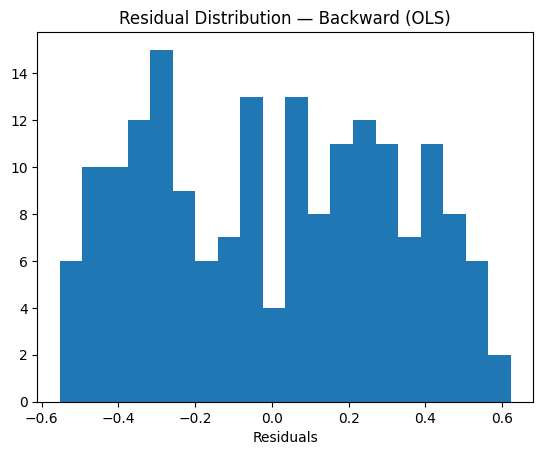

<Figure size 640x480 with 0 Axes>

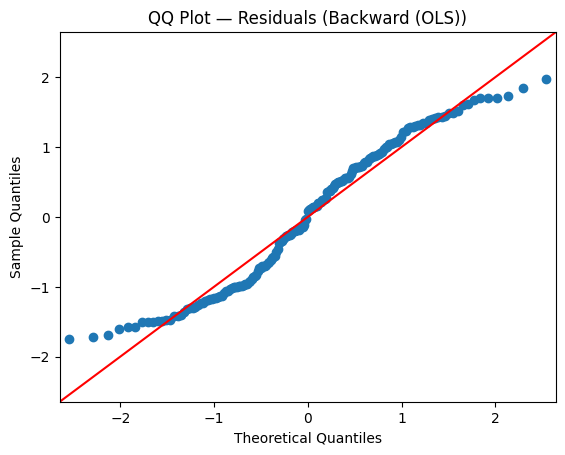

In [11]:
# PURPOSE OF THIS CELL:
# - Print coefficients of the winning OLS model and run residual diagnostics (Residuals vs Fitted, Histogram, QQ plot).

print(f"\n=== Coefficients for {best_name} ===")
print(best_model.params.sort_values())

resid  = best_model.resid
fitted = best_model.fittedvalues

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Fitted — {best_name}")
plt.show()

plt.figure()
plt.hist(resid, bins=20)
plt.xlabel("Residuals")
plt.title(f"Residual Distribution — {best_name}")
plt.show()

plt.figure()
sm.qqplot(resid, line='45', fit=True)
plt.title(f"QQ Plot — Residuals ({best_name})")
plt.show()

## Cell 11 — Quick metrics (winner) + full OLS summary

In [12]:
# PURPOSE OF THIS CELL:
# - Summarize quick metrics (R², Adj R², MAE, RMSE) for the winner and print full OLS summary.

y_hat = best_model.fittedvalues
r2  = best_model.rsquared
adj = best_model.rsquared_adj
mae = float(np.mean(np.abs(y - y_hat)))
rmse = float(np.sqrt(np.mean((y - y_hat)**2)))

print("Best Model Quick Metrics:")
print("R²     :", round(r2, 4))
print("Adj R² :", round(adj, 4))
print("MAE    :", round(mae, 4))
print("RMSE   :", round(rmse, 4))

print("\nFull OLS Summary (Winner):")
print(best_model.summary())

Best Model Quick Metrics:
R²     : 0.8192
Adj R² : 0.8161
MAE    : 0.2765
RMSE   : 0.3159

Full OLS Summary (Winner):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     267.3
Date:                Sat, 11 Oct 2025   Prob (F-statistic):           1.77e-65
Time:                        08:59:03   Log-Likelihood:                -48.240
No. Observations:                 181   AIC:                             104.5
Df Residuals:                     177   BIC:                             117.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

## Baseline model (raw features) sklearn

In [13]:
sk_base = LinearRegression().fit(X_base, y)
y_hat_base = sk_base.predict(X_base)
print("\n--- Baseline (sklearn) ---")
print("Intercept (c):", sk_base.intercept_)
print("Slopes (mᵢ):", dict(zip(X_base.columns, sk_base.coef_)))
print("R² (sklearn):", r2_score(y, y_hat_base))
print("MAE:", mean_absolute_error(y, y_hat_base))
print("RMSE:", np.sqrt(mean_squared_error(y, y_hat_base)))


--- Baseline (sklearn) ---
Intercept (c): 1.3918649294795795
Slopes (mᵢ): {'x1': np.float64(-1.780793573920485)}
R² (sklearn): 0.48419408084826465
MAE: 0.4489040054461125
RMSE: 0.5335262856725673


1) Polynomial features (sklearn) + quick baseline

In [14]:
# PURPOSE:
# - Expand X_base into polynomial features (degree ≤ 4) for sklearn.
# - Fit a plain sklearn LinearRegression on ALL poly features as a baseline.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X_base),
                      columns=poly.get_feature_names_out(X_base.columns))

# Baseline: use all polynomial features
sk_poly_all = LinearRegression().fit(X_poly, y)
y_hat_poly_all = sk_poly_all.predict(X_poly)

print("SKlearn Poly-ALL:")
print("  R²   :", r2_score(y, y_hat_poly_all))
print("  RMSE :", np.sqrt(mean_squared_error(y, y_hat_poly_all)))
print("  #features:", X_poly.shape[1])
print("Head of poly features:")
print(X_poly.head())


SKlearn Poly-ALL:
  R²   : 0.8197720396473178
  RMSE : 0.3153724443036791
  #features: 4
Head of poly features:
         x1      x1^2          x1^3          x1^4
0  0.000000  0.000000  0.000000e+00  0.000000e+00
1  0.005556  0.000031  1.714678e-07  9.525990e-10
2  0.011111  0.000123  1.371742e-06  1.524158e-08
3  0.016667  0.000278  4.629630e-06  7.716050e-08
4  0.022222  0.000494  1.097394e-05  2.438653e-07
